In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [4]:
# INITIALISING PARAMETERS THAT WILL BE USED THROUGHOUT

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3  #RGB
EPOCHS = 50

<p style="color: purple; font-size: 25px;">Data Preprocessing</p>

In [5]:
# Using image_dataset_from_directory to create a dataset from the PlantVillage directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


<p style="color: green; font-size: 15px;">So these are the two main diseases a potato plant faces during its growth that is : Early Blight & Late Blight </p>

<p style="color: purple; font-size: 25px;">Let's Explore dataset now</p>

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 2 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]


<p style="color: green; font-size: 15px;">This (32,256,256,3) means each batch has 32 images of size 256 x 256 with 3 channels (RGB) and the below 0,1,2 for classes where : </p> 
<span style="color: green; font-size: 15px;">0 = Early Blight</span>
<span style="color: green; font-size: 15px;">1 = Late Blight</span>
<span style="color: green; font-size: 15px;">2 = Healthy</span>

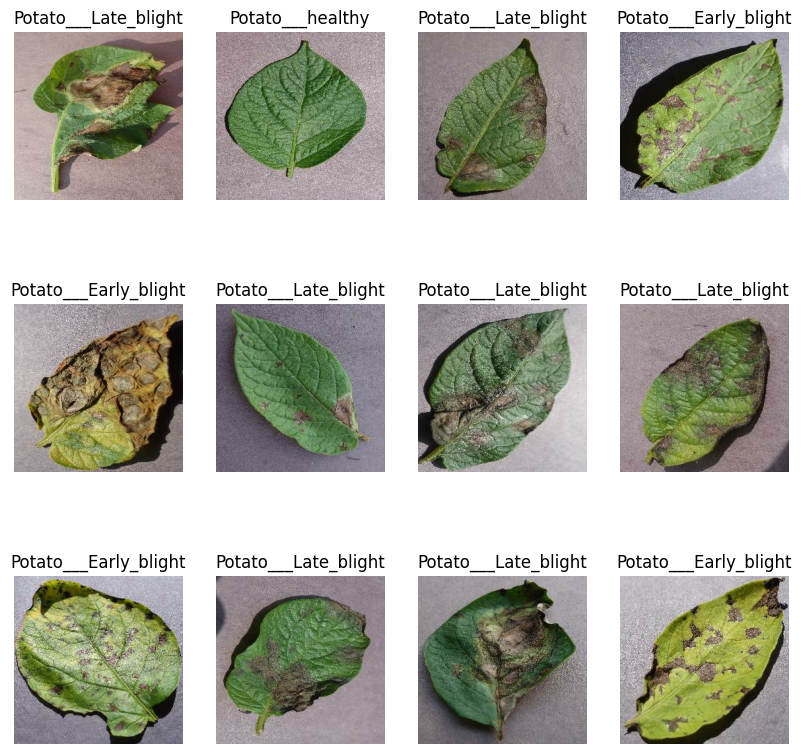

In [8]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

<p style="color: purple; font-size: 25px;">Splitting dataset to train , test and validation set</p>

In [13]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    assert (train_split + val_split + test_split) == 1  # Train, val and test splits must sum to 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

<p style="color: purple; font-size: 25px;">Dataset Performance Optimizations (Cache, Shuffle, Prefetch) :</p>
<p style="color: green; font-size: 15px;">-> Improves data pipeline speed</p>
<p style="color: green; font-size: 15px;">-> Speeds up training significantly </p> 

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

<p style="color: purple; font-size: 25px;">Image Preprocessing (Resize & Rescale)</p>  
<p style="color: green; font-size: 15px;">-> Resizes all images to a fixed size</p>
<p style="color: green; font-size: 15px;">-> Normalizes pixel values to [0, 1] </p> 
<p style="color: green; font-size: 15px;">-> Essential for CNN stability and performance </p> 

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

<p style="color: purple; font-size: 25px;">Data Augmentation Pipeline : </p>  
<p style="color: green; font-size: 15px;">-> Improves generalization</p>  
<p style="color: green; font-size: 15px;">-> Prevents overfitting</p>  
<p style="color: green; font-size: 15px;">-> Applies realistic transformation</p>  

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

<p style="color: purple; font-size: 25px;">Building and training CNN Model</p>  